# Proyecto 4: Informe final de carrera

### Planteamiento del problema

**Dataset**
Características y precios de inmuebles en Buenos Aires ([link](https://drive.google.com/a/acamica.com/uc?export=download&id=1Ugbsw5XbNRbglomSQO1qkAgMFB_3BzmB))

**Objetivo**
Estudiar la viabilidad de mejorar y expandir el área de cobertura de las predicciones mediante la inclusión de métodos adicionales al análisis.

**Métodos a implementar**

* Imputación de datos.
* Inclusión de otros tipos de propiedades.
* Uso del modelo `XGBoost`.

**Preguntas a responder**
* ¿Es posible mejorar el desempeño del modelo imputando valores faltantes?
* ¿Es posible incluir otros tipos de propiedades sin empeorar su desempeño?
* ¿Aplicar un modelo basado en `Boosting` como `XGBosst` tendrá un mejor desempeño en este problema?

**Resultados esperados**

* Imputando datos, se espera una mejora en el desempeño del modelo.
* Incluir otros tipo de propiedades, expandirá la cobertura de predicciones del modelo sin afectar su desempeño.

**Punto de partida**

Este análisis se basará en los resultados encontrados en los dos primeros proyectos que abarcaron el mismo problema:

* __Mejor modelo:__ Random Forest.
* __Métrica:__ RMSE.
* __Features usadas:__

    * Latitud (lat).
    * Longitud (lon).
    * Ambientes (rooms).
    * Habitaciones (bedrooms).
    * Baños (bathrooms > 0).
    * Superficie Total (surface_total <= 1000).
    * Supercifie Cubierta (surface_covered >= 18).
    * Tipo de Propiedad (property_type).
    * Precio (price >= 39000).
    * Barrio (l3).
    * Región (l2 = Capital Federal).

* __Técnicas usadas:__

    * Validar consistencia de datos (e.g. surface_total >= surface_covered).
    * Eliminación de valores atípicos: criterio de los 3 sigmas.
    * PCA manteniendo el 95% de varianza en los datos.


### Preparación de datos

Para comenzar el análisis correspondiente a este notebook, se aplicarán las técnicas necesarias para limpiar el dataset y tener registros válidos.

Se importan las librerías y se definen las constantes y funciones necesarias:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from time import time

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

In [2]:
random_state = 2021-3-6
test_size = 0.1
n_iter = 20
n_processors = -1

In [3]:
def count_removed_rows(initial, final):
    print(f"{initial - final} rows were removed")

def detect_outliers_3_sigma(data, criteria='3sigma'):
    data_description = data.describe()
    data_mean = data_description.loc['mean']
    data_std = data_description.loc['std']
    criteria_max = data_mean + 3 * data_std
    criteria_min = data_mean - 3 * data_std
    return (data < criteria_min) | (data > criteria_max)

def study_model(model, data, scoring="neg_root_mean_squared_error"):
    start = time()

    X_train, y_train = data
    model.fit(X_train, y_train)

    end = time()
    time_elapsed = end - start
    is_time_min = time_elapsed > 60
    if is_time_min:
        time_elapsed = time_elapsed / 60
    print(f"Time elapsed: {time_elapsed:0.4f} {'min' if is_time_min else 'sg'}")

def hyperparameter_optimization(model, params, data, strategy='random', n_iter=10, random_state=random_state, cv=5, scoring='neg_root_mean_squared_error'):
    search = RandomizedSearchCV(model, param_distributions=params, cv=cv, scoring=scoring, n_jobs=n_processors, n_iter=n_iter, random_state=random_state)
    study_model(search, data, scoring=scoring)
    print(f"Iterations: {n_iter}")
    print(f"Search strategy: {strategy}")
    print(f"Best params: {search.best_params_}")
    print(f"Best score ({cv}-fold CV): {-search.best_score_:0.2f} USD")
    return search

def plot_residuals(y, residuals, labels, legend=True):
    plt.figure(figsize=(15,5))
    sns.scatterplot(x=y/1000, y=residuals/1000, hue=labels, legend=legend)
    plt.xlabel('Price (kUSD)')
    plt.ylabel('Residual (kUSD)')
    plt.title('Residuals vs Prices')
    plt.show()
    
def count_missing_values(dataset, figsize=None):
    missing_values_count = pd.DataFrame(dataset.isna().sum(), columns=['count_'])
    missing_values_count['percentage'] = np.round(100 * missing_values_count.count_ / dataset.shape[0], 2)

    if figsize is not None:
        plt.figure(figsize=figsize)
        plt.xticks(rotation = 90)

    g = sns.barplot(x="index", y="count_", data=missing_values_count.reset_index())
    g.set_xlabel("Features")
    g.set_ylabel("Count")
    g.set_title("Missing values")
    
    if figsize is None:
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
    
    plt.show()

Se importan los datos:

In [4]:
dataset = pd.read_csv('properati.csv')
dataset.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


Se conservan únicamente las features mencionadas y se aplican los filtros correspondientes:

In [5]:
initial_shape = dataset.shape[0]

dataset = dataset[['lat', 'lon', 'l2', 'l3', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'property_type', 'price']]
dataset = dataset[dataset.l2 == "Capital Federal"]
dataset.drop(axis=1, columns=["l2"], inplace=True)

count_removed_rows(initial=initial_shape, final=dataset.shape[0])

54121 rows were removed


Se eliminan los registros inválidos:

In [6]:
initial_shape = dataset.shape[0]

valid_registry_criteria = 'rooms >= bedrooms & surface_total >= surface_covered & surface_covered >= 18 & surface_total <= 1000 & bathrooms > 0 & price >= 39000'
dataset.query(valid_registry_criteria, inplace=True)

count_removed_rows(initial=initial_shape, final=dataset.shape[0])

12056 rows were removed


Se removerán los valores atípicos usando el criterio de los 3 sigmas:

In [7]:
initial_shape = dataset.shape[0]

# Removing outliers
numeric_columns = ['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price']
for column in numeric_columns:
    columns_to_keep = ~detect_outliers_3_sigma(dataset[column])
    dataset = dataset[columns_to_keep].copy()
    
count_removed_rows(initial=initial_shape, final=dataset.shape[0])
print(f"Final shape => {dataset.shape}")

8856 rows were removed
Final shape => (71627, 10)


Para poder medir si las técnicas que se desean usar son efectivas y capaces de responder las preguntas planteadas, se debe establecer un procedimiento a seguir. Para cada uno de ellos, se seguirán los siguientes pasos:

1. Se aplicará un `LabelEncoder` y `OneHotEncoder` sobre el tipo de propiedad.
1. Se hará un train/test split donde el test size será de 10%.
1. Se escalarán los datos.
1. Se generarán nuevas variables mediante el uso de PCA manteniendo al menos el 95% de la varianza de los datos.
1. Se entrenará un modelo de `RandomForest`, optimizando sus hiperparámetros usando `RandomizedSearchCV` con CV=5 y 20 iteraciones.
1. Se evaluará el RMSE del modelo en el conjunto de test.
1. Se mostrará un gráfico de los residuos por tipo de propiedad para poder encontrar posibles patrones en las predicciones.

La métrica mencionada, es la que servirá para comparar la efectivadad de los métodos adicionales a aplicar en el presente análisis.

La siguiente función traduce los pasos anteriormente explicados en código:

In [8]:
def perform_analysis(tidy_dataset, test_size, random_state, n_iter, model, hyperparams, n_processors):
    # LabelEncoder & OneHotEncoder.
    property_type_label_encoder = LabelEncoder()
    tidy_dataset['property_type_encoded'] = property_type_label_encoder.fit_transform(tidy_dataset.property_type)

    property_type_one_hot_encoder = OneHotEncoder(sparse=False)
    property_type_encoded = property_type_one_hot_encoder.fit_transform(tidy_dataset.property_type_encoded.to_numpy().reshape(-1, 1))
    tidy_dataset = pd.concat([tidy_dataset.reset_index(drop=True), pd.DataFrame(property_type_encoded, columns=property_type_label_encoder.classes_)], axis=1)
    tidy_dataset.drop(['property_type_encoded'], axis=1, inplace=True)
    tidy_dataset.head()

    # Train/Test split
    label_columns = ['l3', 'property_type']
    X = tidy_dataset.drop(['price'], axis=1)
    y = tidy_dataset.price

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    X_train_labels = X_train[label_columns].copy()
    X_test_labels = X_test[label_columns].copy()

    X_train = X_train.drop(label_columns, axis=1).copy()
    X_test = X_test.drop(label_columns, axis=1).copy()

    # Scaling.
    columns_to_scale = ['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered']
    ct = ColumnTransformer([('scaler', StandardScaler(), columns_to_scale)], remainder='passthrough')

    X_train = pd.DataFrame(ct.fit_transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(ct.transform(X_test), columns=X_test.columns)

    # PCA (95% variance).
    pca_total = PCA(n_components=X_train.shape[1], random_state=random_state)
    pca_total.fit(X_train)
    
    cummulative_explained_variance = np.cumsum(pca_total.explained_variance_ratio_)
    n_components = (cummulative_explained_variance < 0.95).sum() + 1
    print(f'Number of principal components {n_components} ({100 * cummulative_explained_variance[n_components-1]:.2f}%)')

    pca = PCA(n_components=n_components, random_state=random_state)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    # Model Training
    forest_search = hyperparameter_optimization(model=model, params=hyperparams, data=(X_train, y_train), n_iter=n_iter)

    # Model Evaluation
    y_test_pred = forest_search.predict(X_test)
    print(f'Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f} USD')
    
    # Plot Residuals
    residuals = y_test - y_test_pred
    plot_residuals(y=y_test, residuals=residuals, labels=X_test_labels.property_type)

### Benchmark

Se buscará reproducir el análisis de las versiones anteriores para tener un punto de comparación.
En este caso, se filtrará el dataset de la siguiente forma:

* Sólo inmuebles del tipo `Casa`, `Departamento` y `PH`.
* Remover filas con valores faltantes.

In [9]:
initial_shape = dataset.shape[0]

benchmark_dataset = dataset[dataset.property_type.isin(["Casa", "Departamento", "PH"])].copy()
benchmark_dataset.dropna(inplace=True)

count_removed_rows(initial=initial_shape, final=benchmark_dataset.shape[0])

3654 rows were removed


Comanzando con el análisis anteriormente mencionado:

Number of principal components 5 (95.52%)
Time elapsed: 6.2948 min
Iterations: 20
Search strategy: random
Best params: {'max_depth': 25, 'max_features': 'sqrt', 'n_estimators': 152}
Best score (5-fold CV): 29921.32 USD
Test RMSE: 27507.26 USD


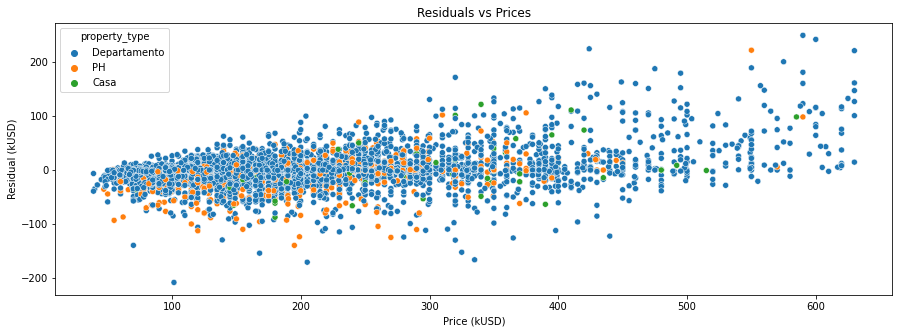

In [10]:
param_distributions = {
    'n_estimators': stats.randint(low=100,high=200),
    'max_depth': stats.randint(low=25,high=50),
    'max_features': ['auto', 'sqrt', 'log2']
}
forest = RandomForestRegressor(random_state=random_state, n_jobs=n_processors)
perform_analysis(model=forest, hyperparams=param_distributions, tidy_dataset=benchmark_dataset, test_size=test_size, random_state=random_state, n_iter=n_iter, n_processors=n_processors)

### ¿Es posible mejorar el desempeño del modelo imputando valores faltantes?

En la sección anterior se aplicaron dos filtros:

* Tipo de propiedad: `Casa`, `Departamento` y `PH`.
* Descartar filas con valores faltantes.

En este caso, sólo se aplicará el filtrado por propiedad:

In [11]:
initial_shape = dataset.shape[0]

dataset_impute_missing = dataset[dataset.property_type.isin(["Casa", "Departamento", "PH"])].reset_index(drop=True).copy()

count_removed_rows(initial=initial_shape, final=dataset_impute_missing.shape[0])

321 rows were removed


A continuación un conteo de los valores faltantes:

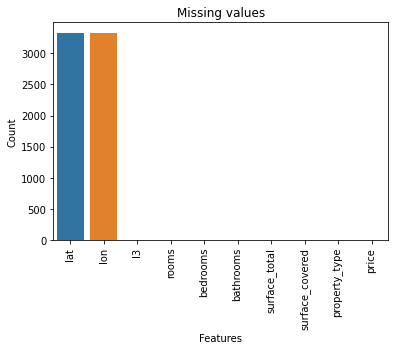

In [12]:
count_missing_values(dataset_impute_missing)

Para el dataset en el estado que se encuentra ahora, sólo existen valores faltantes en las columnas de latitud y longitud.

Existen varias estrategias a considerar al momento de querer imputar valores como usar el promedio, la mediana o un valor fijo. Sin embargo, considerando la naturaleza del dato estas estrategias estándar no tendrían sentido. Por ejemplo podemos tomar el promedio. Usando el promedio para imputar los datos significaría que los casi 3.000 inmuebles se encuentran ubicados en el centro de Buenos Aires (como un edificio en el pleno centro). Esto sólo generaría más inconsistencia en los datos y entraría en conflicto con el valor de la columna `l3` (barrio).

Una aproximación que se podría tomar es el promedio por barrio. Lo cual supondría que las propiedades se encontrarían en el centro de los respectivos barrios. Esto último no crearía un conflictos en los datos.
La imputación de valores se hará tanto con el promedio como con la mediana.

Se contruirá una función que servirá para realizar el análisis para ambos casos:

In [13]:
lat_lon_statistic = dataset[['lat', 'lon', 'l3']].copy()
lat_lon_statistic.rename(columns={'lat': 'lat_statistic', 'lon': 'lon_statistic'}, inplace=True)

def lat_lon_imputation(dataset, lat_lon_statistic, random_state=random_state, n_processors=n_processors, test_size=test_size, n_iter=n_iter):
    # Get all statistics for each row
    dataset_regions = dataset[['l3']].copy()
    dataset_regions = pd.merge(left=dataset_regions, right=lat_lon_statistic, on='l3', how='left')
    
    # Impute latitude
    lat_missing_values = dataset.lat.isna()
    dataset.lat.fillna(dataset_regions.lat_statistic[lat_missing_values.values], inplace=True)
    
    # Impute longitude
    lon_missing_values = dataset.lon.isna()
    dataset.lon.fillna(dataset_regions.lon_statistic[lon_missing_values.values], inplace=True)
    
    print(f"Missing latitude values: {dataset.lat.isna().sum()}")
    print(f"Missing longitude values: {dataset.lon.isna().sum()}")
    
    # Train and evaluate model
    param_distributions = {
        'n_estimators': stats.randint(low=100,high=200),
        'max_depth': stats.randint(low=25,high=50),
        'max_features': ['auto', 'sqrt', 'log2']
    }
    forest = RandomForestRegressor(random_state=random_state, n_jobs=n_processors)
    perform_analysis(model=forest, hyperparams=param_distributions, tidy_dataset=dataset, test_size=test_size, random_state=random_state, n_iter=n_iter, n_processors=n_processors)

Haciendo la imputación del promedio por barrio:

Missing latitude values: 0
Missing longitude values: 0
Number of principal components 5 (95.58%)
Time elapsed: 6.8199 min
Iterations: 20
Search strategy: random
Best params: {'max_depth': 26, 'max_features': 'sqrt', 'n_estimators': 174}
Best score (5-fold CV): 30469.06 USD
Test RMSE: 29425.42 USD


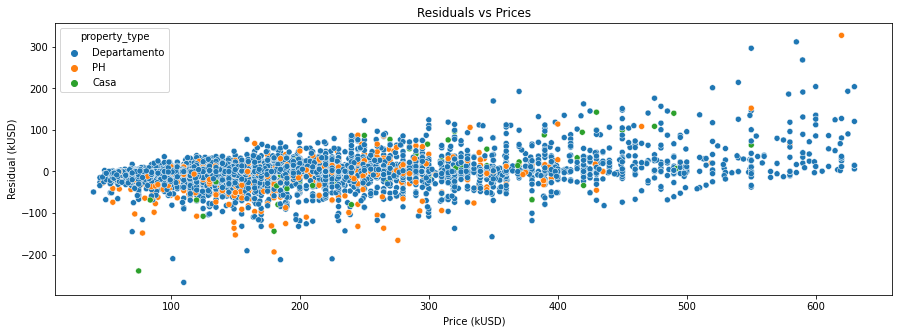

In [14]:
lat_lon_imputation(dataset=dataset_impute_missing.copy(), lat_lon_statistic=lat_lon_statistic.groupby('l3').mean().reset_index().copy())

Ahora una imputación de la mediana por barrio:

Missing latitude values: 0
Missing longitude values: 0
Number of principal components 5 (95.58%)
Time elapsed: 6.9939 min
Iterations: 20
Search strategy: random
Best params: {'max_depth': 46, 'max_features': 'log2', 'n_estimators': 195}
Best score (5-fold CV): 30545.92 USD
Test RMSE: 29479.92 USD


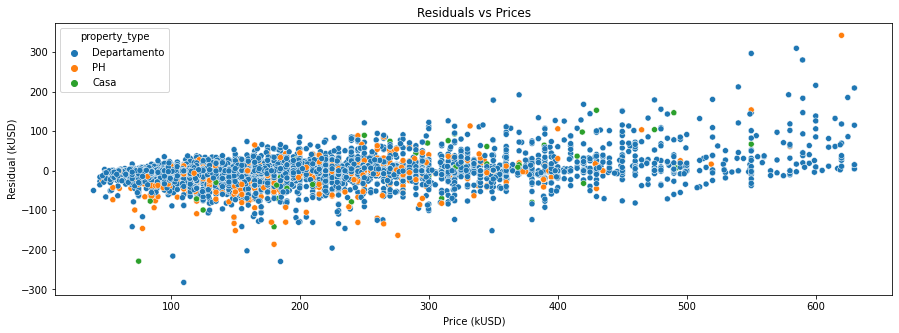

In [15]:
lat_lon_imputation(dataset=dataset_impute_missing.copy(), lat_lon_statistic=lat_lon_statistic.groupby('l3').median().reset_index().copy())

En ambos casos se evidencia un aumento en el error lo cual nos indica que el método de imputación de datos no ayuda a mejorar el desempeño del modelo.

### ¿Es posible incluir otros tipos de propiedades sin empeorar su desempeño?

Para este caso, únicamente se eliminarán las filas con valores faltantes:

In [16]:
initial_shape = dataset.shape[0]

all_properties_dataset = dataset.copy()
all_properties_dataset.dropna(inplace=True)

count_removed_rows(initial=initial_shape, final=all_properties_dataset.shape[0])
other_properties_shape = all_properties_dataset[~all_properties_dataset.property_type.isin(["Casa", "Departamento", "PH"])].shape
print(f"Other properties shape: {other_properties_shape}")

3348 rows were removed
Other properties shape: (306, 10)


La cantidad de registros adicionados al dataset es relativamente baja (< 1%). Con los datos preparados para el entrenamiendo, se comienza con el proceso:

Number of principal components 5 (95.44%)
Time elapsed: 6.7595 min
Iterations: 20
Search strategy: random
Best params: {'max_depth': 26, 'max_features': 'sqrt', 'n_estimators': 174}
Best score (5-fold CV): 29891.38 USD
Test RMSE: 28575.67 USD


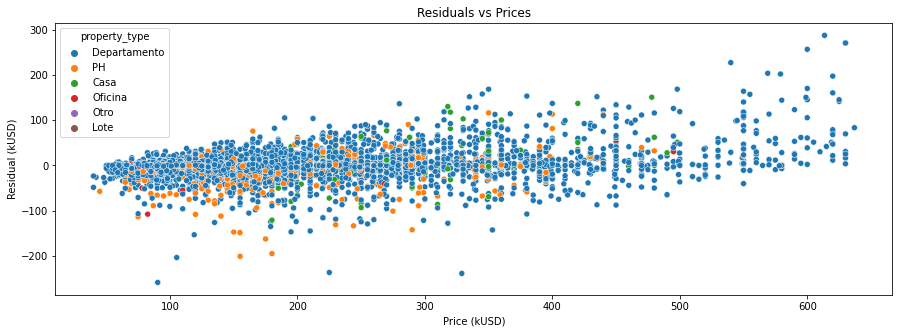

In [17]:
param_distributions = {
    'n_estimators': stats.randint(low=100,high=200),
    'max_depth': stats.randint(low=25,high=50),
    'max_features': ['auto', 'sqrt', 'log2']
}
forest = RandomForestRegressor(random_state=random_state, n_jobs=n_processors)
perform_analysis(model=forest, hyperparams=param_distributions, tidy_dataset=all_properties_dataset, test_size=test_size, random_state=random_state, n_iter=n_iter, n_processors=n_processors)

A pesar de la baja cantidad de registros adicionados (300 aprox), el peso del error es equivalente al obtenido al de la pregunta anterior donde si incluyeron muchos más registros (3.000 aprox). Comparando ambos gráficos de residuos vemos que en este caso tenemos residuos que alcanzan los USD 300.000 mientras que en original, rondan los USD 200.000. Esto sugiere que los patrones que relacionan a los inmuebles `Casa`, `Departamento` y `PH` son diferentes al resto por lo que puede convenir hacer un modelo a parte para estos últimos.

Se puede concluir así que incluir otras propiedades no agrega valor al desempeño del modelo.

### ¿Aplicar un modelo basado en `Boosting` como `XGBoost` tendrá un mejor desempeño en este problema?

Bagging y boosting son dos conceptos de ensamblaje de modelos que aprovechan diferentes estados de los modelos (overfitting vs underfitting) para lograr un mejor desempeño en conjunto. Dos exponentes de los más conocidos en ambos conceptos son Random Forest y XGBoost respectivamente. Ambos se basan (con sus excepciones) en el mismo modelo: Árbol de Decisión.

A diferencia del Random Forest, XGBoost se basa en sacar provecho de varios modelos con underfitting y del descenso por gradiente para ajustar los errores de los mismos. Dado que el modelo de Random Forest dio buenos resultados sobre las predicciones, valdría el esfuerzo probar con este modelo y comparar resultados.

En primer lugar, se llevará el dataset al mismo punto que el usado en el benchmark para poder hacer una comparación correcta entre modelos:

In [18]:
initial_shape = dataset.shape[0]

xgb_dataset = dataset[dataset.property_type.isin(["Casa", "Departamento", "PH"])].copy()
xgb_dataset.dropna(inplace=True)

count_removed_rows(initial=initial_shape, final=xgb_dataset.shape[0])

3654 rows were removed


Dado que XGBoost tiene una API compatible con Scikit Learn, se puede sacar ventaja de las classes y métodos que esta última ofrece en su librería.
Los hiperparámetros a optimizar, serán los siguientes:

* `n_estimators:` número de árboles de decisión a usar en el modelo.
* `booster:` Se usarán dos, `gbtree` para usar un ensamblaje de árboles de decisión y [DART](https://xgboost.readthedocs.io/en/latest/tutorials/dart.html) el cual agrega a los ensamblajes técnicas usadas en redes neuronales.
* `learning_rate:` usando en las operaciones del descenso por gradiente (se incluirá el valor por defecto `None` en las opciones).

Comanzando el entrenamiendo:

Number of principal components 5 (95.52%)
Time elapsed: 6.9557 min
Iterations: 20
Search strategy: random
Best params: {'booster': 'gbtree', 'learning_rate': None, 'n_estimators': 195}
Best score (5-fold CV): 35455.98 USD
Test RMSE: 34461.32 USD


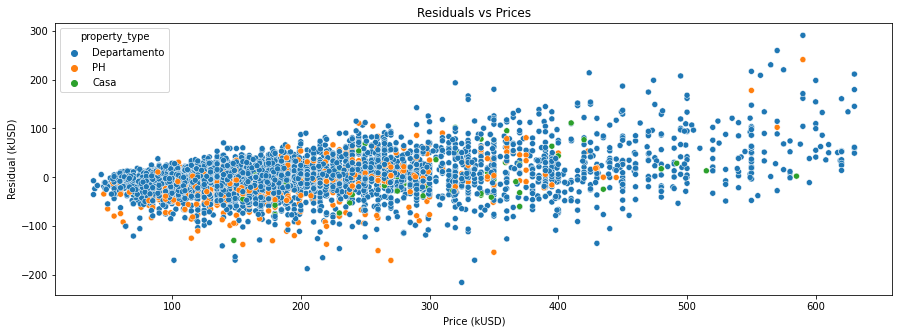

In [20]:
param_distributions = {
    'n_estimators': stats.randint(low=100,high=200),
    'booster': ['gbtree', 'dart'],
    'learning_rate': [0.05, 0.1, None],
}
xgb = XGBRegressor(objective='reg:squarederror', random_state=random_state, n_jobs=n_processors)
perform_analysis(model=xgb, hyperparams=param_distributions, tidy_dataset=xgb_dataset, test_size=test_size, random_state=random_state, n_iter=n_iter, n_processors=n_processors)

Se puede observar que el error del modelo `XGBoost` es mucho mayor que el benchmark por lo que concluímos que este modelo, para este problema particular puede ser descartado.

### Análisis de resultados

**¿Es posible mejorar el desempeño del modelo imputando valores faltantes?**

La latitud y longitud son campos con propiedades particulares. De situaciones de la vida real, se sabe que dentro de un mismo barrio pueden existir diferentes zonas con niveles enconómicos diferentes. Esto depende mucho de la localidad. Considerando lo anteriormente dicho, puede explicarse por qué la técnica aplicada no tuvo el efecto deseado.

El hacer la imputación considerando el promedio o mediana por barrio es equivalente a decir que todas esas propiedades (ya sea `Casa`, `Departamento` o `PH`) se encuentran sobre un mismo punto (e.g. un mismo edificio) en el centro de la localidad lo cual se puede llegar a contradecir, en algunos casos, lo expresado en el párrafo anterior. Con ello podría explicarse el deterioro en el desempeño.

Podría considerarse otras técnicas como `KNNImputer`, sin embargo esta técnica conlleva una cantidad de cálculos que podría no compensar el valor de una posible mejora. Otra estrategia que podría pensarse es imputar los valores no sólo considerando los barrios sino tambien los precios, pero hacer esto generará un `memory leak` que creará una ilusión de mejora en el desempeño cuando en realidad, los datos de entrenamiento poseerán pistas sobre el valor real de la propiedad.

Con los datos y estrategias que se cuentan en estos momentos, la respuesta a esta pregunta es no.

**¿Es posible incluir otros tipos de propiedades sin empeorar su desempeño?**

El uso de la clase `OneHotEncoder` es de mucha utilidad al momento de incluir nuevos tipos de propiedades implementando el código adecuado. Sin embargo, a pesar de ser una cantidad relativamente pequeña de filas las que fueron incluidas, el efecto sobre el desempeño es muy grande. Por ello, se puede pensar que un modelo por separado puede ayudar a la inclusión de estos.

Un punto a destacar es que, para asegurar un buen desempeño y generalización de los resultados sobre los pocos datos con los que se cuentan, es:

* Validar que son una muestra representativa de la población de las propiedades diferentes de `Casa`, `Departamento` o `PH`.
* Aumentar la cantidad de datos (considerando el punto anterior).

La respuesta para esta pregunta es: Posible, pero debe realizarse un análisis por separado para estas propiedades.

**¿Aplicar un modelo basado en `Boosting` como `XGBoost` tendrá un mejor desempeño en este problema?**

Para el problema planteado, `XGBoost` tuvo un peor desempeño que `Random Forest`, de forma tal que el modelo `XGBoost` puede ser descartado. La respuesta a esta pregunta es no.

### Conclusiones

* El modelo original se mantiene como la mejor opción para llevar a producción.
* Los tres procedimientos implementados en este análisis no agregan valor al desempeño del modelo obtenido en notebooks anteriores.
* A pesar que las respuestas a las tres preguntas fueron negativas, se pudo aplicar 3 estrategias diferentes no implementadas en las fases anteriores del proyecto.
* Posibles puntos de mejora:

    * Para la expansión de la cobertura de los tipos de propiedad puede considerarse entrenar un modelo a parte.
    * Pueden hacerse uso de modelos basados en redes neuronales para poder encontrar mejores desempeños sobre el problema siempre teniendo en cuenta la escalabilidad del modelo.
    * Posiblemente puede obtenerse un mejor desempeño usando técnicas de NLP sobre las descripciones para encontrar features relevantes (e.g. si tiene piscina, calefacción central, etc).